In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, PathPatch
import matplotlib.collections as mcoll
from matplotlib import font_manager
import json
try:
    if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
        mpl.rcParams["font.family"] = "Fira Sans"
    else:
        raise KeyError("No Fira Sans? :3")
except:
    try:
        for font in os.listdir(os.path.join(os.path.dirname(os.getcwd()), "fonts")):
            font_manager.fontManager.addfont(os.path.join(os.path.join(os.path.dirname(os.getcwd()), "fonts"), font))
        font_manager.fontManager = font_manager.FontManager()
        if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
            mpl.rcParams["font.family"] = "Fira Sans"
        else:
            raise ValueError("No Fira Sans in fonts folder...")
    except:
        mpl.rcParams["font.family"] = "DejaVu Sans"
tgss = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'TgSS_enriched_cleaned.csv'))
tgss["Polymer Class"] = tgss["Polymer Class"].str.replace("sufonates", "sulfonates", case=False, regex=False)

In [2]:
y_PC = tgss["Polymer Class"]
q = []
for pocat in np.unique(y_PC):
    q.extend(pocat.lower().replace('\t', '').split(", "))
multi_labels = np.array(sorted(list(set(np.unique(q))-set(['other polymers']))))
multi_labeled = [{label: label in pc.lower() for label in multi_labels} for pc in y_PC]
df_cols = pd.DataFrame(multi_labeled, columns=multi_labels)
tgss = pd.concat([tgss, df_cols], axis=1)

In [3]:
new_cols = [d[0] for d in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(new_cols)
results = []
for smiles in tqdm(tgss["SMILES"]):
    results.append(calculator.CalcDescriptors(Chem.MolFromSmiles(smiles)))
df_cols_feat = pd.DataFrame(results, columns=new_cols)
tgss_merged = pd.concat([tgss, df_cols_feat], axis=1)

100%|██████████| 7284/7284 [01:46<00:00, 68.13it/s] 


In [4]:
tgss_merged.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'featurized_TgSS.csv'))

In [2]:
with open(os.path.join(os.getcwd(), "plotting_help.json"), "r") as f:
    plotting_help = json.load(f)
abbrev = plotting_help["abbrev"]
colors = plotting_help["colors"]
hatches = plotting_help["hatches"]

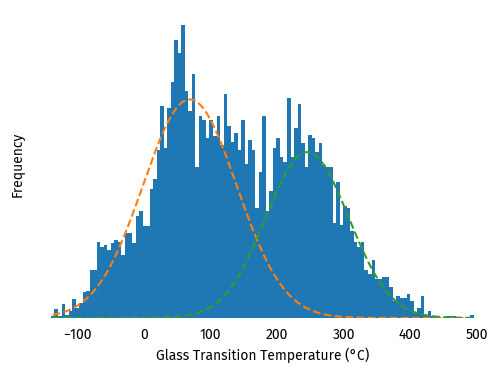

In [6]:
fig, ax = plt.subplots(figsize = (6,4))
bin_c = 120
ax.hist(tgss["Tg"], bin_c)

counts, bin_edges = np.histogram(tgss["Tg"], bins=bin_c)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
def two_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x-mu1)**2/(2*sigma1**2)) +
            A2 * np.exp(-(x-mu2)**2/(2*sigma2**2)))
p0 = [max(counts), np.percentile(tgss["Tg"], 30), np.std(tgss["Tg"]),
      max(counts)/2, np.percentile(tgss["Tg"], 70), np.std(tgss["Tg"])/2]
popt, pcov = curve_fit(two_gaussians, bin_centers, counts, p0=p0)
A1, mu1, sigma1, A2, mu2, sigma2 = popt
counts, bin_edges = np.histogram(tgss["Tg"], bins=bin_c)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
sigma = np.sqrt(np.var(tgss["Tg"]))
xmin, xmax = plt.xlim()
amplitude = len(tgss["Tg"])*(xmax-xmin)/bin_c
mean = np.mean(tgss["Tg"])
x = np.linspace(bin_centers.min(), bin_centers.max(), 400)
ax.plot(x, A1*np.exp(-(x-mu1)**2/(2*sigma1**2)), linestyle="--")
ax.plot(x, A2*np.exp(-(x-mu2)**2/(2*sigma2**2)), linestyle="--")
ax.set_yticks([])
ax.set_ylabel("Frequency")
ax.tick_params(left = False, bottom = False)
ax.set_xlabel("Glass Transition Temperature (°C)")
for _, spine in ax.spines.items():
    spine.set_visible(False)


C:\Users\Andy\AppData\Local\Temp\ipykernel_41744\708384302.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_violin.set_xticklabels([abbrev[x] for x in median_order], rotation=90)


(0.0, 1.0)

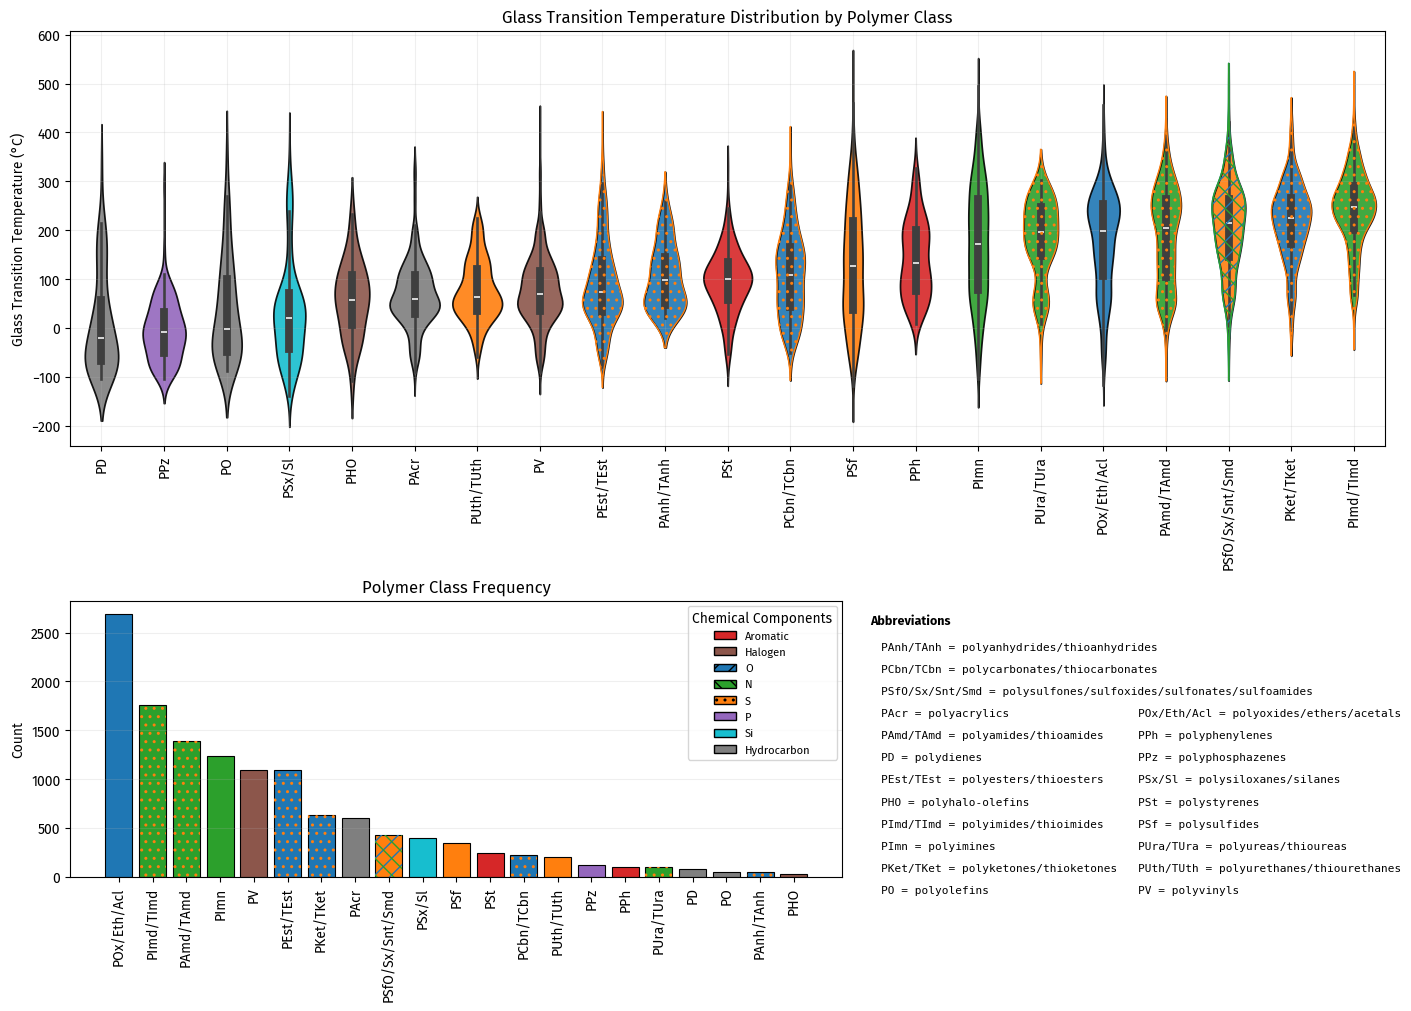

In [7]:
def detect_components(label):
    l = label.lower()
    components = {
        "Aromatic": 0,
        "Halogen": 0,
        "O": 0,
        "S": 0,
        "N": 0,
        "P": 0,
        "Si": 0,
    }
    components["Aromatic"] += len(re.findall(r'styren|phenyl|phenylen|arom', l))
    components["Halogen"] += len(re.findall(r'halo|vinyl|chloro|fluoro|bromo|iodo', l))
    components["O"] += len(re.findall(r'oxide|ester|carbonate|ketone|anhyd|acetal|ether', l))
    components["S"] += len(re.findall(r'sulf|sulfo|thio', l))
    components["N"] += len(re.findall(r'amide|urea|imine|imide', l))
    components["P"] += l.count("phosph")
    components["Si"] += len(re.findall(r'silox|silan', l))
    total = sum(components.values())
    if total == 0:
        return {"Hydrocarbon": 1.0}
    return {k: v/total for k,v in components.items() if v > 0}

long = tgss.melt(id_vars="Tg", value_vars=df_cols.columns,
                 var_name="PolymerClass", value_name="Present")
median_order = long[long["Present"]].groupby("PolymerClass")["Tg"].median().sort_values().index
fig = plt.figure(figsize=(14,10), constrained_layout=True)
gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[3, 2],
    width_ratios=[3, 2],
    figure=fig
)
ax_violin = fig.add_subplot(gs[0, :])
sns.violinplot(
    data=long[long["Present"]],
    x="PolymerClass",
    y="Tg",
    order=median_order,
    ax=ax_violin
)
bodies = [c for c in ax_violin.collections
          if isinstance(c, mcoll.PolyCollection)]
for body, label in zip(bodies, median_order):
    comp = detect_components(label)
    main = max(comp, key=comp.get)
    body.set_facecolor(colors.get(main, "#7f7f7f"))
    body.set_edgecolor("black")
    body.set_alpha(0.9)
    for comp_type, val in comp.items():
        if comp_type != main and val > 0:
            patch = PathPatch(body.get_paths()[0],
                facecolor="none",
                edgecolor=colors.get(comp_type,"black"),
                hatch=hatches.get(comp_type,""),
                zorder=4
            )
            ax_violin.add_patch(patch)
ax_violin.set_xticklabels([abbrev[x] for x in median_order], rotation=90)
ax_violin.set_xlabel("")
ax_violin.set_title("Glass Transition Temperature Distribution by Polymer Class")
ax_violin.set_ylabel("Glass Transition Temperature (°C)")
ax_violin.grid(alpha=0.2)
ax_bar = fig.add_subplot(gs[1, 0])
label_counts = df_cols.sum().sort_values(ascending=False)
x = range(len(label_counts))
for i, label in enumerate(label_counts.index):
    comp = detect_components(label)
    main = max(comp, key=comp.get)
    ax_bar.bar(i, label_counts[label],
               color=colors.get(main, "#7f7f7f"),
               edgecolor="black",
               linewidth=0.8,
               zorder=0)
    for comp_type, val in comp.items():
        if comp_type != main and val > 0:
            ax_bar.bar(i, label_counts[label],
                       facecolor="none",
                       edgecolor=colors.get(comp_type,"black"),
                       hatch=hatches.get(comp_type,""),
                       linewidth=0.0,
                       zorder=3)
ax_bar.set_xticks(list(x))
ax_bar.set_xticklabels(
    [abbrev[label] for label in label_counts.index],
    rotation=90
)
ax_bar.set_title("Polymer Class Frequency")
ax_bar.set_ylabel("Count")
ax_bar.grid(axis='y', alpha=0.2)
legend_patches = [
    Patch(facecolor=color,
          edgecolor="black",
          hatch=hatches.get(comp, ""),
          label=comp)
    for comp, color in colors.items()
]
ax_bar.legend(handles=legend_patches,
              title="Chemical Components",
              loc="upper right",
              fontsize=8)
ax_leg = fig.add_subplot(gs[1, 1])
ax_leg.axis("off")
items = list(abbrev.items())
LONG_THRESHOLD = 28
long_items   = [(full, short) for full, short in items if len(full) > LONG_THRESHOLD]
short_items  = [(full, short) for full, short in items if len(full) <= LONG_THRESHOLD]
ax_leg.text(0.0, 0.95, "Abbreviations",
            fontsize=9, weight='bold', va='top')
y = 0.85
line_step = 0.08
FONT = 8
for full, short in long_items:
    ax_leg.text(0.02, y, f"{short} = {full}",
                fontsize=FONT, family="monospace", va='top')
    y -= line_step
mid = (len(short_items) + 1) // 2
col1 = short_items[:mid]
col2 = short_items[mid:]
ys = [y - line_step*i for i in range(max(len(col1), len(col2)))]
for (full, short), yy in zip(col1, ys):
    ax_leg.text(0.02, yy, f"{short} = {full}",
                fontsize=FONT, family="monospace", va='top')
for (full, short), yy in zip(col2, ys):
    ax_leg.text(0.52, yy, f"{short} = {full}",
                fontsize=FONT, family="monospace", va='top')
ax_leg.set_xlim(0,1)
ax_leg.set_ylim(0,1)

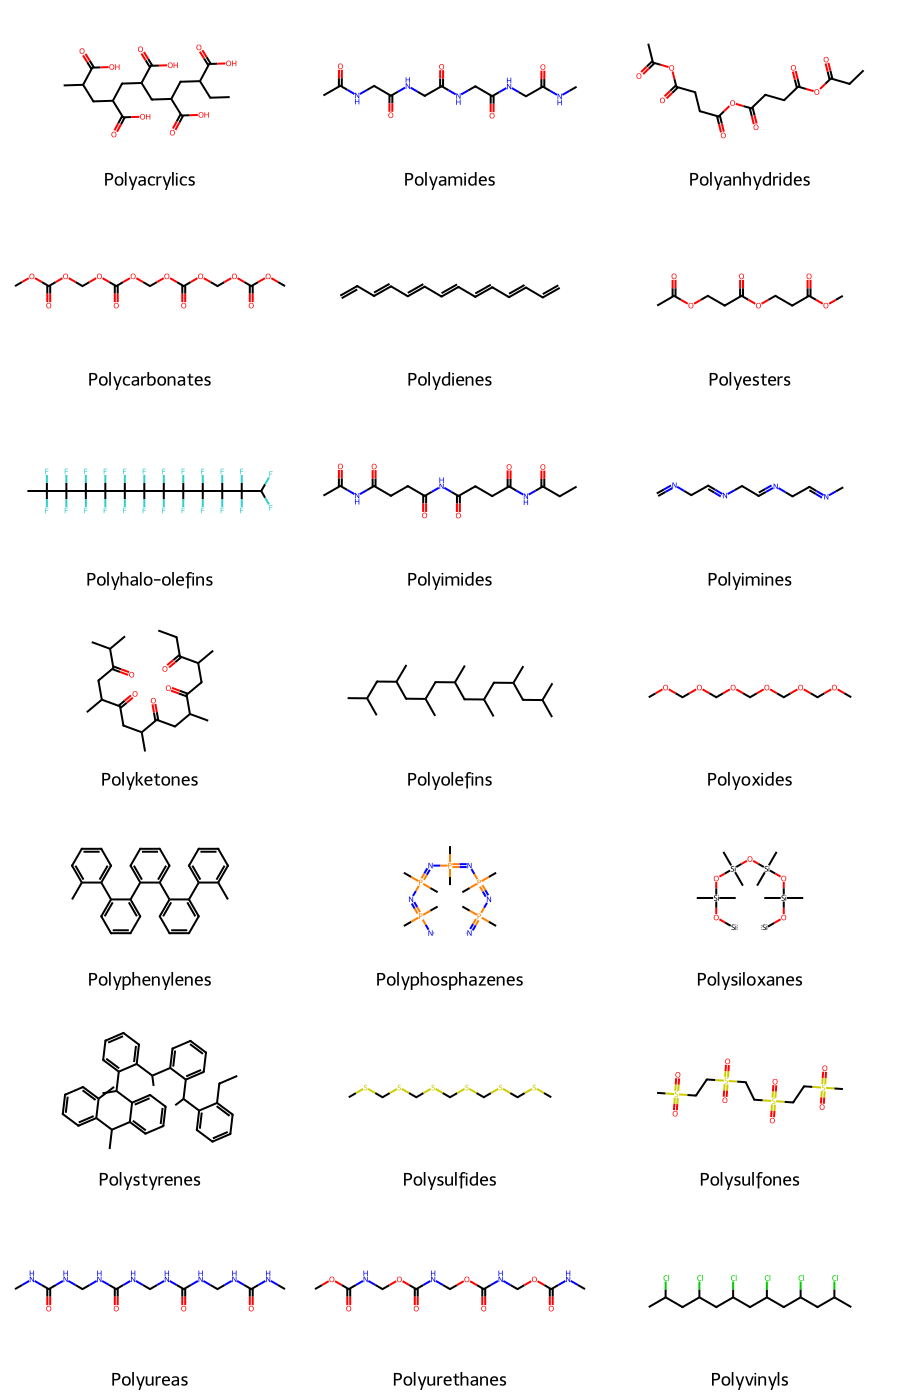

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
polymers = {
    "Polyacrylics": "CC(C(=O)O)CC(C(=O)O)CC(C(=O)O)CC(C(=O)O)CC(C(=O)O)CC",
    "Polyamides": "CC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NC",
    "Polyanhydrides": "CC(=O)OC(=O)CCC(=O)OC(=O)CCC(=O)OC(=O)CC",
    "Polycarbonates": "COC(=O)OCOC(=O)OCOC(=O)OCOC(=O)OC",
    "Polydienes": "C=CC=CC=CC=CC=CC=CC=C",
    "Polyesters": "CC(=O)OCCC(=O)OCCC(=O)OC",
    "Polyhalo-olefins": "C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C",
    "Polyimides": "CC(=O)NC(=O)CCC(=O)NC(=O)CCC(=O)NC(=O)CC",
    "Polyimines": "C=NCC=NCC=NCC=NC",
    "Polyketones": "CC(C)C(=O)CC(C)C(=O)CC(C)C(=O)CC(C)C(=O)CC(C)C(=O)CC",
    "Polyolefins": "CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)C",
    "Polyoxides": "COCOCOCOCOCOC",
    "Polyphenylenes": "Cc1ccccc1c1ccccc1c1ccccc1c1ccccc1c1ccccc1C",
    "Polyphosphazenes": "[N]P(C)(C)=NP(C)(C)=NP(C)(C)=NP(C)(C)=NP(C)(C)=[N]",
    "Polysiloxanes": "[Si]O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si]",
    "Polystyrenes": "C(C)c1ccccc1C(C)c1ccccc1C(C)c1ccccc1C(C)c1ccccc1C(C)c1ccccc1C",
    "Polysulfides": "CSCSCSCSCSCSC",
    "Polysulfones": "CS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)C",
    "Polyureas": "CNC(=O)NCNC(=O)NCNC(=O)NCNC(=O)NC",
    "Polyurethanes": "COC(=O)NCOC(=O)NCOC(=O)NCOC(=O)NC",
    "Polyvinyls": "CC(Cl)CC(Cl)CC(Cl)CC(Cl)CC(Cl)CC(Cl)C"
}
mols = []
labels = []
opts = Draw.MolDrawOptions()
opts.legendFontSize = 100
for name, smile in polymers.items():
    mol = Chem.MolFromSmiles(smile)
    mols.append(mol)
    labels.append(name)
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(300,200),
    legends=labels,
    drawOptions=opts,
)
display(img)
